<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/FineTunedChemberta(DeepChem_SmilesTokenizer_PubChem_1M).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fined Tuned pretained Chemberta(DeepChem_ChemBERTa_77M_MLM) -- classification modeling

## Introduction

 By directly accepting SMILES strings as input, ChemBERTa eliminates the need for extensive featurization, thus facilitating rapid screening(Ahmad et al., 2022; Chithrananda et al., 2020). We utilized twelve different variants of CheMERTa, pre-trained in different size and type of dataset, along with rigorous hyper parameter optimization via Optuna module (Chithrananda et al., 2020). Preferred tokenizer was the default RoBERTA tokenizer as there was no significant difference in performance across different tokenizers.


## Data loading and Preprocessing



In [1]:
import numpy as np
# Set random seed
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.1.dev'

In [4]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/Part_2_standarizationOfMolecule/StandarizedSmiles_cutOFF800daltonMolecularweight.xlsx')
df.head()

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,tSNE1,tSNE2,MolecularWeight,Frequency,cleanedMol
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,-52.761700,-42.736099,275.352,27,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,-63.027809,-53.765778,325.364,1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,-61.968063,-54.078575,263.293,1,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,57.758297,-8.911607,212.296,4,Cc1ccc2c(N)c3c(nc2c1)CCCC3
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,61.242554,5.783804,341.455,3,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2


In [5]:
df['classLabel'].value_counts()

classLabel
0    2330
1    1747
Name: count, dtype: int64

In [6]:
df_selected= df[['Smiles', 'classLabel']]
df_selected

,Smiles,classLabel
0,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,1
1,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,1
2,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,0
3,Cc1ccc2c(N)c3c(nc2c1)CCCC3,1
4,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,1
...,...,...
4072,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,1
4073,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],0
4074,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],0
4075,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],1


 The following code for roberta tokenizer and chemberta model building is adopted from deepchem's tutorial: (https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

In [8]:
df.to_csv('inhibitor.csv', index=False)

In [9]:
import deepchem as dc

In [10]:
dataset_file = 'inhibitor.csv'
task = ['classLabel']
featurizer_func = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=task, feature_field='cleanedMol', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

In [11]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

In [12]:
from rdkit import Chem

In [13]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

fatal: destination path 'apex' already exists and is not an empty directory.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Processing ./apex
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
    Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)
    Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
    Creating /tmp/pip-build-env-gwobcpuw/overlay/local/bin
    changing mode of /tmp/pip-build-env-gwobcpuw/overlay/local/bin/wheel to 755
  ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
  ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Installing build dependencies ... done
  Running command Getting requirements to build wheel
  Traceback (most recent call last):
    File "/usr/local/lib/python3.10/dist-packages/pip/

In [14]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [15]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

fatal: destination path 'bert-loves-chemistry' already exists and is not an empty directory.


In [16]:
%cd /content/bert-loves-chemistry

/content/bert-loves-chemistry


In [17]:
import os
import numpy as np
import pandas as pd
from typing import List
from rdkit import Chem

In [18]:
!pip install transformers

In [19]:
import deepchem as dc
import pandas as pd
task = ['classLabel']

dataset = dc.data.NumpyDataset(X=df['cleanedMol'], y=df['classLabel'])

splitter = dc.splits.RandomSplitter()
frac_train = 0.7
frac_valid = 0.15
frac_test = 0.15

# Split the dataset
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset, frac_train=frac_train, frac_valid=frac_valid, frac_test=frac_test
)

In [20]:
test_dataset

<NumpyDataset X.shape: (612,), y.shape: (612,), w.shape: (612,), ids: [3356 2744 3859 ... 860 3507 3174], task_names: [0]>

In [21]:
train_df = train_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()

In [22]:
train_df

,X,y,w,ids
0,Clc1ccc(CN2CCN(c3nccc(NCc4ccccc4)n3)CC2)cc1,0,1.0,1749
1,CCCCNC(=O)Oc1cccc(CN(C)CCCOc2ccc3ccc(=O)oc3c2)c1,1,1.0,2053
2,Cc1cccc(C[n+]2ccc(C(=O)NCCc3c[nH]c4ccccc34)cc2)c1,0,1.0,538
3,CN(C)CCCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2,1,1.0,438
4,COc1cc2c(cc1OC)SC(C(=O)CCc1cc[n+](Cc3ccsc3)cc1)C2,1,1.0,2685
...,...,...,...,...
2848,CC1=Nc2nc3c(c(N)c2C(c2ccccc2F)C1C(=O)OC1CCC1)C...,1,1.0,2927
2849,COc1cc2c(cc1OC)C(c1ccccc1)N(CCCCCCc1cc(C)nc(C=...,0,1.0,375
2850,CC1CN(C(=O)Oc2ccc(Oc3ccc(C(F)(F)F)cn3)cc2)CC(C)O1,0,1.0,1908
2851,CN(C)Cc1ccc(CSCCCCCCCCCCSCc2ccc(CN(C)C)o2)o1,0,1.0,333


In [23]:
train_df=train_df[['X','y']]
valid_df=valid_df[['X','y']]
test_df=test_df[['X','y']]

## Model Building

In [24]:
from simpletransformers.classification.classification_model import ClassificationModel
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [25]:
from simpletransformers.classification.classification_model import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'DeepChem/SmilesTokenizer_PubChem_1M', use_cuda=True, args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}, ignore_mismatched_sizes=True) # You can set class weights by using the optional weight argument


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/334M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized because the shapes did not match:
- embeddings.word_embeddings.weight: found shape torch.Size([52000, 768]) in the checkpoint and torch.Size([591, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [26]:
!mkdir AChE_transferLearning4
# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/AChE_transferLearning4')

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/357 [00:00<?, ?it/s]

(3570, 0.418506994033728)

## Cross Species Evaluation

### Upload and prep for species dataset

Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.





In [27]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndependent.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mosquito.xlsx')

In [28]:
df_humanIndependent = dc.data.NumpyDataset(X=df_humanIndependent['cleanedMol'], y=df_humanIndependent['binary_activities'])
df_eel = dc.data.NumpyDataset(X=df_eel['cleanedMol'], y=df_eel['single-class-label'])
df_mouse = dc.data.NumpyDataset(X=df_mouse['cleanedMol'], y=df_mouse['single-class-label'])
df_cow = dc.data.NumpyDataset(X=df_cow['cleanedMol'], y=df_cow['single-class-label'])
df_ray = dc.data.NumpyDataset(X=df_ray['cleanedMol'], y=df_ray['single-class-label'])
df_mosquito = dc.data.NumpyDataset(X=df_mosquito['cleanedMol'], y=df_mosquito['single-class-label'])

In [29]:
df_humanIndependent = df_humanIndependent.to_dataframe()
df_eel = df_eel.to_dataframe()
df_mouse = df_mouse.to_dataframe()
df_cow = df_cow.to_dataframe()
df_ray = df_ray.to_dataframe()
df_mosquito = df_mosquito.to_dataframe()

In [30]:
df_humanIndependent=df_humanIndependent[['X','y']]
df_eel=df_eel[['X','y']]
df_mouse=df_mouse[['X','y']]
df_cow=df_cow[['X','y']]
df_ray=df_ray[['X','y']]
df_mosquito=df_mosquito[['X','y']]

In [31]:
df_humanIndependent

,X,y
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0
...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1


### Cross species evaluation

In [32]:
import pandas as pd
import numpy as np
import sklearn

all_results = []
all_model_outputs = []
all_wrong_predictions = []

datasets = [df_humanIndependent, df_eel, df_mouse, df_cow, df_ray, df_mosquito]

species_names = ['humanIndependent', 'eel', 'mouse', 'cow', 'ray', 'mosquito']

for dataset, species_name in zip(datasets, species_names):
    # Convert NumpyDataset to Pandas DataFrame
    data_dict = {'cleanedMol': np.asarray(dataset.X), 'single-class-label': np.asarray(dataset.y)}
    current_df = pd.DataFrame(data_dict)

    # Perform evaluation
    result_test, model_outputs_test, wrong_predictions_test = model.eval_model(current_df, acc=sklearn.metrics.accuracy_score)

    # Append results for the current species to the lists
    all_results.append(pd.DataFrame({'Species': [species_name], 'Accuracy': [result_test]}))
    all_model_outputs.append(pd.DataFrame({'Species': [species_name], 'Model Outputs': [model_outputs_test]}))
    all_wrong_predictions.append(pd.DataFrame({'Species': [species_name], 'Wrong Predictions': [wrong_predictions_test]}))

# Concatenate all results DataFrames
results_df = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df.to_excel('all_results.xlsx', index=False)
model_outputs_df.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
import sklearn.metrics

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

evaluation_results = {}

for dataset_name, dataset in datasets.items():
    result, model_outputs, wrong_predictions = model.eval_model(dataset, acc=sklearn.metrics.accuracy_score)
    evaluation_results[dataset_name] = {
        'result': result,
        'model_outputs': model_outputs,
        'wrong_predictions': wrong_predictions
    }

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
for dataset_name, result in evaluation_results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Evaluation result: {result['result']}")
    print()

Dataset: Human Test
Evaluation result: {'mcc': 0.59924073265995, 'accuracy': 0.803921568627451, 'f1_score': 0.7991840484758331, 'tp': 199, 'tn': 293, 'fp': 67, 'fn': 53, 'auroc': 0.8580577601410935, 'auprc': 0.8184307525045149, 'acc': 0.803921568627451, 'eval_loss': 0.8934416600636074}

Dataset: Human Independent
Evaluation result: {'mcc': 0.28758841015962355, 'accuracy': 0.6538461538461539, 'f1_score': 0.6360454943132108, 'tp': 45, 'tn': 91, 'fp': 47, 'fn': 25, 'auroc': 0.7022774327122153, 'auprc': 0.6470647362729625, 'acc': 0.6538461538461539, 'eval_loss': 1.5540513197580974}

Dataset: Eel
Evaluation result: {'mcc': 0.2654363944504549, 'accuracy': 0.6420589851621176, 'f1_score': 0.6304140570970823, 'tp': 1268, 'tn': 2237, 'fp': 1138, 'fn': 816, 'auroc': 0.6899004052036682, 'auprc': 0.5847497171480884, 'acc': 0.6420589851621176, 'eval_loss': 1.5878604905171827}

Dataset: Mouse
Evaluation result: {'mcc': 0.45921687894477814, 'accuracy': 0.7282608695652174, 'f1_score': 0.723947550034506

In [37]:
import pandas as pd

# Convert evaluation_results dictionary to a DataFrame
df_evaluation_results = pd.DataFrame(evaluation_results)

# Transpose the DataFrame so that datasets are in rows and metrics are in columns
df_evaluation_results = df_evaluation_results.T
df_evaluation_results



,result,model_outputs,wrong_predictions
Human Test,"{'mcc': 0.59924073265995, 'accuracy': 0.803921...","[[-2.380859375, 2.0859375], [3.60546875, -3.07...","[{'guid': 14, 'text_a': 'C#CCN(C)Cc1cc2cc(OCCC..."
Human Independent,"{'mcc': 0.28758841015962355, 'accuracy': 0.653...","[[-3.01171875, 2.91015625], [-2.8046875, 2.210...","[{'guid': 4, 'text_a': 'C[n+]1c2c(c(N)c3ccccc3..."
Eel,"{'mcc': 0.2654363944504549, 'accuracy': 0.6420...","[[-3.224609375, 3.01953125], [-1.2470703125, 1...","[{'guid': 3, 'text_a': 'O=C1Nc2ccccc2/C1=C\\c1..."
Mouse,"{'mcc': 0.45921687894477814, 'accuracy': 0.728...","[[-0.344970703125, 0.255126953125], [-2.191406...","[{'guid': 4, 'text_a': 'CN(CCC1CCN(Cc2ccccc2)C..."
Cow,"{'mcc': 0.5654767367054746, 'accuracy': 0.7833...","[[-3.091796875, 2.84375], [-3.197265625, 2.886...","[{'guid': 33, 'text_a': 'CCN(C)C(=O)Oc1cccc2c1..."
Ray,"{'mcc': 0.2302854076336439, 'accuracy': 0.6152...","[[-3.193359375, 3.05859375], [-3.224609375, 3....","[{'guid': 38, 'text_a': 'CCN(CC)Cc1ccc(OC2Cc3c..."
Mosquito,"{'mcc': 0.5465943944999486, 'accuracy': 0.7916...","[[2.5078125, -2.099609375], [2.630859375, -2.3...","[{'guid': 1, 'text_a': 'COc1ccc(NC(=S)NCCN2CCO..."


Confusion Matrix for Human Test dataset:
[[293  67]
 [ 53 199]]
Confusion Matrix for Human Independent dataset:
[[91 47]
 [25 45]]
Confusion Matrix for Eel dataset:
[[2237 1138]
 [ 816 1268]]
Confusion Matrix for Mouse dataset:
[[157  66]
 [ 34 111]]
Confusion Matrix for Cow dataset:
[[165  53]
 [ 46 193]]
Confusion Matrix for Ray dataset:
[[444 275]
 [266 421]]
Confusion Matrix for Mosquito dataset:
[[42  3]
 [12 15]]


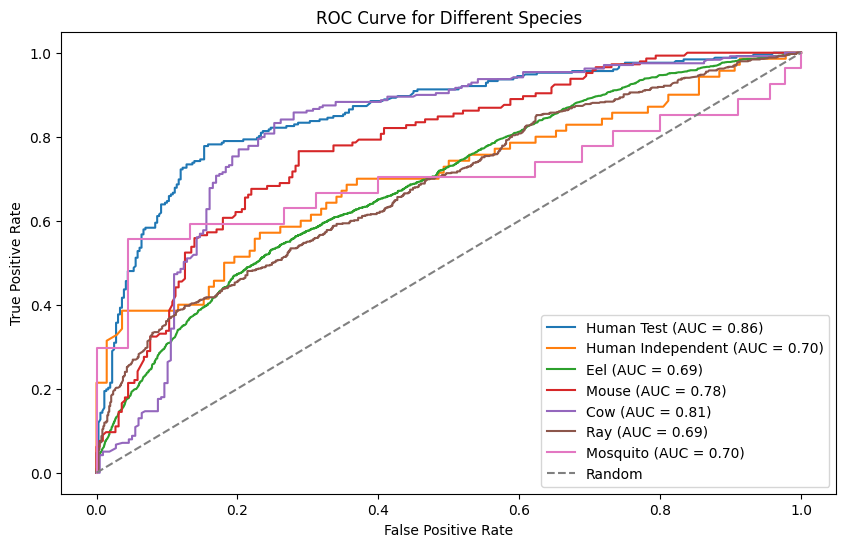

Evaluation for Human Test dataset:
Accuracy: 0.8039
Precision: 0.7481
Recall: 0.7897
F1 Score: 0.7683
MCC: 0.5992
Cohen's Kappa: 0.5986


Evaluation for Human Independent dataset:
Accuracy: 0.6538
Precision: 0.4891
Recall: 0.6429
F1 Score: 0.5556
MCC: 0.2876
Cohen's Kappa: 0.2806


Evaluation for Eel dataset:
Accuracy: 0.6421
Precision: 0.5270
Recall: 0.6084
F1 Score: 0.5648
MCC: 0.2654
Cohen's Kappa: 0.2635


Evaluation for Mouse dataset:
Accuracy: 0.7283
Precision: 0.6271
Recall: 0.7655
F1 Score: 0.6894
MCC: 0.4592
Cohen's Kappa: 0.4521


Evaluation for Cow dataset:
Accuracy: 0.7834
Precision: 0.7846
Recall: 0.8075
F1 Score: 0.7959
MCC: 0.5655
Cohen's Kappa: 0.5652


Evaluation for Ray dataset:
Accuracy: 0.6152
Precision: 0.6049
Recall: 0.6128
F1 Score: 0.6088
MCC: 0.2303
Cohen's Kappa: 0.2303


Evaluation for Mosquito dataset:
Accuracy: 0.7917
Precision: 0.8333
Recall: 0.5556
F1 Score: 0.6667
MCC: 0.5466
Cohen's Kappa: 0.5238




,Accuracy,Precision,Recall,F1 Score,MCC,Cohen's Kappa
Human Test,0.803922,0.748120,0.789683,0.768340,0.599241,0.598583
Human Independent,0.653846,0.489130,0.642857,0.555556,0.287588,0.280553
Eel,0.642059,0.527016,0.608445,0.564811,0.265436,0.263474
Mouse,0.728261,0.627119,0.765517,0.689441,0.459217,0.452104
Cow,0.783370,0.784553,0.807531,0.795876,0.565477,0.565209
Ray,0.615220,0.604885,0.612809,0.608821,0.230285,0.230267
Mosquito,0.791667,0.833333,0.555556,0.666667,0.546594,0.523810


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Evaluate and plot ROC curve for each dataset
for species, result in evaluation_results.items():
    y_true = datasets[species].y.ravel()
    y_pred_positive = result['model_outputs'][:, 1]

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_positive)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Calculate the confusion matrix
    y_pred_binary = np.argmax(result['model_outputs'], axis=1)  # Convert probabilities to binary predictions
    conf_matrix = confusion_matrix(y_true, y_pred_binary)

    # Calculate other evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    cohen_kappa = cohen_kappa_score(y_true, y_pred_binary)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa
    }

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(conf_matrix)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics


## Model optimization

In [40]:
!pip install Optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [45]:
import os
import optuna
from sklearn.metrics import roc_auc_score
from simpletransformers.classification.classification_model import ClassificationModel

classification_args = {
    'overwrite_output_dir': True,  # Set to True to overwrite the output directory if it exists
}

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 10)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 1000)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-9, 1e-7, log=True)
    output_dir = f'/content/AChE_transferLearning_trial_{trial.number}'

    # Create and train the model with the given hyperparameters
    model = ClassificationModel('roberta', 'DeepChem/SmilesTokenizer_PubChem_1M',ignore_mismatched_sizes=True, use_cuda=True, args={**classification_args, 'learning_rate': learning_rate, 'num_train_epochs': num_train_epochs, 'train_batch_size': batch_size, 'dropout': dropout, 'warmup_steps': warmup_steps, 'weight_decay': weight_decay, 'adam_epsilon': adam_epsilon})

    model.train_model(train_df, eval_df=valid_df)  # Pass valid_df for evaluation

    # Evaluate the model and calculate ROC AUC
    eval_results = model.eval_model(valid_df)
    predictions, _ = model.predict(valid_df['X'].tolist())
    roc_auc = roc_auc_score(valid_df['y'].tolist(), predictions)

    # Return ROC AUC for optimization
    return roc_auc

# Create an Optuna study and optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2024-06-18 06:38:45,377] A new study created in memory with name: no-name-2d787f08-aa30-40b8-a134-81534636789e
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized because the shapes did not match:
- embeddings.word_embeddings.weight: found shape torch.Size([52000, 768]) in the checkpoint and torch.Size([591, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletrans

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:40:28,386] Trial 0 finished with value: 0.6761133162960142 and parameters: {'learning_rate': 1.4743183660162873e-05, 'num_train_epochs': 6, 'batch_size': 32, 'dropout': 0.3161441214116102, 'warmup_steps': 543, 'weight_decay': 0.13381964151484635, 'adam_epsilon': 3.429211477331991e-09}. Best is trial 0 with value: 0.6761133162960142.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 1 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 4 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 5 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 6 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 7 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 8 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 9 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:42:45,927] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.0006693193881596467, 'num_train_epochs': 9, 'batch_size': 32, 'dropout': 0.339316230549378, 'warmup_steps': 331, 'weight_decay': 0.19813791966147806, 'adam_epsilon': 3.4709116034146562e-09}. Best is trial 0 with value: 0.6761133162960142.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:44:29,201] Trial 2 finished with value: 0.7149149040291447 and parameters: {'learning_rate': 2.5207535339343934e-05, 'num_train_epochs': 5, 'batch_size': 16, 'dropout': 0.24403908004050306, 'warmup_steps': 0, 'weight_decay': 0.0840621593170518, 'adam_epsilon': 2.2110027877679773e-08}. Best is trial 2 with value: 0.7149149040291447.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:45:41,734] Trial 3 finished with value: 0.6282638246968625 and parameters: {'learning_rate': 1.6659259799543848e-05, 'num_train_epochs': 4, 'batch_size': 16, 'dropout': 0.13089196102370934, 'warmup_steps': 867, 'weight_decay': 0.22675749919854038, 'adam_epsilon': 1.3946658561838106e-08}. Best is trial 2 with value: 0.7149149040291447.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:46:48,546] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 0.0006136781360993765, 'num_train_epochs': 3, 'batch_size': 16, 'dropout': 0.49165416103737136, 'warmup_steps': 694, 'weight_decay': 0.20274833156036406, 'adam_epsilon': 3.123203197804827e-09}. Best is trial 2 with value: 0.7149149040291447.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infere

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:49:13,397] Trial 5 finished with value: 0.6414985590778098 and parameters: {'learning_rate': 5.728678170880219e-06, 'num_train_epochs': 8, 'batch_size': 16, 'dropout': 0.2576340967590696, 'warmup_steps': 71, 'weight_decay': 0.11054874132843218, 'adam_epsilon': 1.0022527664477762e-08}. Best is trial 2 with value: 0.7149149040291447.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/357 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:51:10,841] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 0.00017953679559332917, 'num_train_epochs': 5, 'batch_size': 8, 'dropout': 0.12512491955129282, 'warmup_steps': 114, 'weight_decay': 0.20987651048044806, 'adam_epsilon': 1.3878390721901616e-08}. Best is trial 2 with value: 0.7149149040291447.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 7 of 7:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:53:11,185] Trial 7 finished with value: 0.7639715078027296 and parameters: {'learning_rate': 2.078856027310025e-05, 'num_train_epochs': 7, 'batch_size': 16, 'dropout': 0.34757108747666554, 'warmup_steps': 430, 'weight_decay': 0.24864063242008816, 'adam_epsilon': 4.632702287290869e-08}. Best is trial 7 with value: 0.7639715078027296.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:54:22,262] Trial 8 finished with value: 0.5206459681365886 and parameters: {'learning_rate': 3.00867683664939e-06, 'num_train_epochs': 4, 'batch_size': 32, 'dropout': 0.1146318076128719, 'warmup_steps': 871, 'weight_decay': 0.2435387826144807, 'adam_epsilon': 2.7441521844639365e-09}. Best is trial 7 with value: 0.7639715078027296.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-06-18 06:56:13,334] Trial 9 finished with value: 0.7610896634223262 and parameters: {'learning_rate': 5.9575031598413344e-05, 'num_train_epochs': 6, 'batch_size': 16, 'dropout': 0.2205459583211778, 'warmup_steps': 50, 'weight_decay': 0.19562762889450122, 'adam_epsilon': 1.5839621513256347e-09}. Best is trial 7 with value: 0.7639715078027296.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Best Hyperparameters: {'learning_rate': 2.078856027310025e-05, 'num_train_epochs': 7, 'batch_size': 16, 'dropout': 0.34757108747666554, 'warmup_steps': 430, 'weight_decay': 0.24864063242008816, 'adam_epsilon': 4.632702287290869e-08}


RuntimeError: Error(s) in loading state_dict for RobertaForSequenceClassification:
	size mismatch for embeddings.word_embeddings.weight: copying a param with shape torch.Size([52000, 768]) from checkpoint, the shape in current model is torch.Size([591, 768]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [46]:
# Train the final model with the best hyperparameters
final_model = ClassificationModel('roberta', 'DeepChem/SmilesTokenizer_PubChem_1M',ignore_mismatched_sizes=True, use_cuda=True, args={**classification_args, **best_params})
final_model.train_model(train_df, eval_df=valid_df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/SmilesTokenizer_PubChem_1M and are newly initialized because the shapes did not match:
- embeddings.word_embeddings.weight: found shape torch.Size([52000, 768]) in the checkpoint and torch.Size([591, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

Running Epoch 7 of 7:   0%|          | 0/357 [00:00<?, ?it/s]

(2499, 0.5650864089606237)

In [47]:
best_params

{'learning_rate': 2.078856027310025e-05,
 'num_train_epochs': 7,
 'batch_size': 16,
 'dropout': 0.34757108747666554,
 'warmup_steps': 430,
 'weight_decay': 0.24864063242008816,
 'adam_epsilon': 4.632702287290869e-08}

### Optimized model cross species evaluation

In [48]:
import pandas as pd
import numpy as np
import sklearn

all_results = []
all_model_outputs = []
all_wrong_predictions = []

datasets = [df_humanIndependent, df_eel, df_mouse, df_cow, df_ray, df_mosquito]

species_names = ['humanIndependent', 'eel', 'mouse', 'cow', 'ray', 'mosquito']

for dataset, species_name in zip(datasets, species_names):
    # Convert NumpyDataset to Pandas DataFrame
    data_dict = {'cleanedMol': np.asarray(dataset.X), 'single-class-label': np.asarray(dataset.y)}
    current_df = pd.DataFrame(data_dict)

    # Perform evaluation
    result_test_final, model_outputs_final, wrong_predictions_final = final_model.eval_model(current_df, acc=sklearn.metrics.accuracy_score)

    # Append results for the current species to the lists
    all_results.append(pd.DataFrame({'Species': [species_name], 'Accuracy': [result_test_final]}))
    all_model_outputs.append(pd.DataFrame({'Species': [species_name], 'Model Outputs': [model_outputs_final]}))
    all_wrong_predictions.append(pd.DataFrame({'Species': [species_name], 'Wrong Predictions': [wrong_predictions_final]}))

# Concatenate all results DataFrames
results_df_final = pd.concat(all_results, ignore_index=True)

# Concatenate all model outputs DataFrames
model_outputs_df_final = pd.concat(all_model_outputs, ignore_index=True)

# Concatenate all wrong predictions DataFrames
wrong_predictions_df_final = pd.concat(all_wrong_predictions, ignore_index=True)

# Save concatenated DataFrames to a single Excel file
results_df_final.to_excel('all_results.xlsx', index=False)
model_outputs_df_final.to_excel('all_model_outputs.xlsx', index=False)
wrong_predictions_df_final.to_excel('all_wrong_predictions.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
import sklearn.metrics

datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent,
    'Eel': df_eel,
    'Mouse': df_mouse,
    'Cow': df_cow,
    'Ray': df_ray,
    'Mosquito': df_mosquito
}

evaluation_results = {}

for dataset_name, dataset in datasets.items():
    result_final, model_outputs_final, wrong_predictions_final = final_model.eval_model(dataset, acc=sklearn.metrics.accuracy_score)
    evaluation_results[dataset_name] = {
        'result': result_final,
        'model_outputs': model_outputs_final,
        'wrong_predictions': wrong_predictions_final
    }


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
for dataset_name, result in evaluation_results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Evaluation result: {result['result']}")
    print()


Dataset: Human Test
Evaluation result: {'mcc': 0.5091952300049097, 'accuracy': 0.7598039215686274, 'f1_score': 0.7541261837412373, 'tp': 186, 'tn': 279, 'fp': 81, 'fn': 66, 'auroc': 0.8282297178130511, 'auprc': 0.8021266054849049, 'acc': 0.7598039215686274, 'eval_loss': 0.588389481816973}

Dataset: Human Independent
Evaluation result: {'mcc': 0.4872701501486284, 'accuracy': 0.7596153846153846, 'f1_score': 0.740829346092504, 'tp': 51, 'tn': 107, 'fp': 31, 'fn': 19, 'auroc': 0.8035714285714285, 'auprc': 0.7238657027966109, 'acc': 0.7596153846153846, 'eval_loss': 0.6093448102474213}

Dataset: Eel
Evaluation result: {'mcc': 0.32342199672054905, 'accuracy': 0.6722843011540576, 'f1_score': 0.6601382387046171, 'tp': 1319, 'tn': 2351, 'fp': 1024, 'fn': 765, 'auroc': 0.7299474656998649, 'auprc': 0.6506928410902797, 'acc': 0.6722843011540576, 'eval_loss': 0.7291473220695149}

Dataset: Mouse
Evaluation result: {'mcc': 0.45961045699259795, 'accuracy': 0.7228260869565217, 'f1_score': 0.720147918406

## References


*  https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb
*   https://huggingface.co/DeepChem

*  Ramsundar, B., Eastman, P., Walters, P., Pande, V., Leswing, K., & Wu, Z. (2019). Deep Learning for the Life Sciences. O’Reilly Media. https://www.amazon.com/Deep-Learning-Life-Sciences-Microscopy/dp/1492039837

*  Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283


*   Ahmad, W., Simon, E., Chithrananda, S., Grand, G., & Ramsundar, B. (2022). ChemBERTa-2: Towards Chemical Foundation Models (arXiv:2209.01712). arXiv. http://arxiv.org/abs/2209.01712
*   Chithrananda, S., Grand, G., & Ramsundar, B. (2020). ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction (Version 2). arXiv. https://doi.org/10.48550/ARXIV.2010.09885
